In [180]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [181]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

Downloading a sample of MNIST that contains images of just 3's and 7's

It is split into two folders train/3 and train/7

In [182]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Now we're going to create a tensor containing all of the 3s stacked together, and another for the 7s

In [183]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

To show an image from a tensor, we can use fastai's built-in method called show_image()

<Axes: >

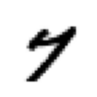

In [184]:
show_image(seven_tensors[1])

Now we need to combine all the images into a 3-dimensional tensor and stakc them into a single one using PyTorch's stack function.

<Axes: >

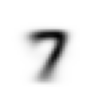

In [185]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

mean7 = stacked_sevens.mean(0)
mean3 = stacked_threes.mean(0)

show_image(mean7)

At this stage, we need to come up with a way of finding out the distance between a test digit and the ideal one. We can do this either using the mean absolute difference (L1) or using root mean squared error (L2)

In [186]:
a_3 = stacked_threes[1]

a_7 = stacked_sevens[1]

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_7_abs = (a_7 - mean7).abs().mean()
dist_7_sqr = ((a_7 - mean7)**2).mean().sqrt()

dist_3_abs, dist_3_sqr, dist_7_abs, dist_7_sqr

(tensor(0.1114), tensor(0.2021), tensor(0.1304), tensor(0.2585))

PyTorch also offers these distance measuring techniques as loss functions (F is in placement of torch.nn.functional)

In [187]:
F.l1_loss(a_3, mean3), F.mse_loss(a_3, mean3)

(tensor(0.1114), tensor(0.0408))

Now, we'll create the validation set by turning all images into a 3-dimensional tensor and stack them into a single one like we did before. 

In [188]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls().sorted()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls().sorted()])

valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255

Now, we'll turn mse into its own function

Note: we use mean((-1,-2)) because we want to take the mean across the last two dimensions (height and width) so that we take the mean of all pixels and end up with a single value.

In [189]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(valid_3_tens, mean3)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

With this distance function , we can create the is_3 function which uses the following logic:
    - If the digit is lower in distance to a 3 than to a 7, then return that it's a 3.

In [190]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

With the is_3() function in place, now we want to see how accurate our current method is. Since PyTorch allows us to use casting, we can turn the boolean value of True/False to 1.0/0.0

To calculate the accuracy, we just take the average of the is_3() function casted to a float. When applying this to the digit 7, we have to take its inverse.

In [191]:
accuracy_3 = is_3(valid_3_tens).float().mean()
accuracy_7 = 1 - is_3(valid_7_tens).float().mean()

accuracy_3, accuracy_7, (accuracy_3 + accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### Now, we're going to use a neural network on this dataset to come up with a model that will automatically improve itself.

The first thing we need to do is combine the `stacked_3s` and `stacked_7s` into one tensor. Each image in this tensor also needs to be converted into a vector of 784 pixels. 

This massive tensor will become our training set.

In [192]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Then we need to come up with a tensor containing the corresponding labels to our training set

In [193]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

Now that we have the data and corresponding labels, we create a dataset as required by PyTorch where it returns a tuple (data, label) when indexed

In [194]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

We then also create the validation dataset using the same method as before:

In [195]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Finally we can start our 7 step process for SGD. So were going to initialize random weights for every pixel and also create a bias too:

In [196]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()
weights = init_params((28*28,1))
bias = init_params(1)

2. Now we're going to make a prediction for a single image

In [197]:
(train_x[0]*weights.T).sum() + bias

tensor([13.7827], grad_fn=<AddBackward0>)

This looks great. So now we're going to make predictions on all the images in the training set. 

We don't want to use a for loop because that would mean using the CPU to create the predictions = SLOW, BAD

So instead we use the `@` operator to have the GPU perform matrix multiplication. We'll define this in a function because the course tells us to.

In [198]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[13.7827],
        [ 8.8101],
        [ 4.3911],
        ...,
        [ 4.9411],
        [-5.3717],
        [10.7604]], grad_fn=<AddBackward0>)

Next we determine how accurate our predictions our with our current parameters

In [199]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [ True],
        [False]])

In [200]:
corrects.float().mean().item()

0.48265570402145386

Awesome, with this accuracy in mind we now have to come up with the best loss function. We can't use accuracy as a loss function because it usually doesn't improve with small changes to our weights. The only times it improves is when there is a larger proportion of correct images. This happens when a prediction flips from wrong to right and vice versa. 

To improve our parameters we need meaningful gradients to work with. We can't use accuracy as a ways to calculate gradient because it would yield a gradient of 0, or infinity when a weight causes a prediction to cross the decision threshold of 0.5.

Basically, we need continuous data to bring us to allow us to create a true gradient where bad predictions are penalized more (the loss goes down) and good predictions are rewarded more (the loss increases).

This loss function, called `mnist_loss` takes two arguments:

`prds`: A rank-1 tensor containing predicted probabilties that an image is a 3 (0 ... 1)

`trgts`: A rank-1 tensor containing the actual label for the image (0,1)

In [201]:
# EXAMPLE
trgts   = tensor([1,0,1])
prds    = tensor([0.9, 0.4, 0.2])

def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

loss1 = mnist_loss(prds, trgts)
loss2 = mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

loss1, loss2

(tensor(0.4333), tensor(0.2333))

This is a good first start at our loss function because when we change our prediction for the one "false" target, the loss goes down.

The major problem with our current implementation of the loss function is that it assumes that predictions will always between 0 and 1.

So now we will implement the sigmoid function that will ensure that our predictions will always be between 0 and 1.

At its core, this is the sigmoid function:

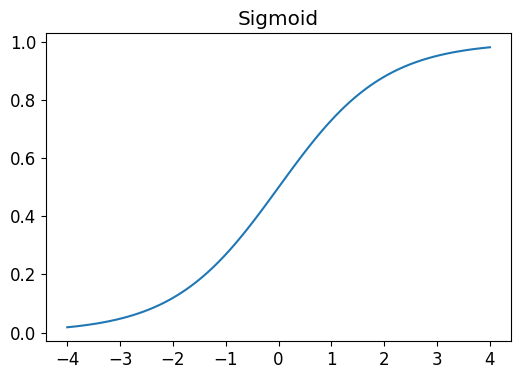

In [202]:
def sigmoid(x): return 1 / (1+torch.exp(-x))
plot_function(torch.sigmoid, title="Sigmoid", min=-4, max=4)

Now that we have a way of ensuring our predictions will always be between 0 and 1, let's use PyTorch's version of the sigmoid function (since it is optimized for cuda) into our `mnist_loss` function:

In [203]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

loss1 = mnist_loss(prds, trgts)
loss2 = mnist_loss(tensor([0.9, 0.4, 0.8]), trgts)

loss1, loss2

(tensor(0.4460), tensor(0.3993))

Now that we have a proper loss function, we now want to start the optimization step. We need to calculate average loss for one or more items in the dataset in order to change/update our weights. 
- More items = more accurate weights and stable estimation of parameters at the cost of longer time per epoch
- Less items = more batches to work on per epoch (busy GPU = happy GPU) but the weights are less accurate

The optimization step will use mini-batch SGD where the data items are shuffled at every epoch.

This is achieved using Pytorch/fastai DataLoader

In [204]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 7,  4,  2,  5, 14]),
 tensor([ 8,  3,  6, 13,  1]),
 tensor([ 0, 11,  9, 12, 10])]

For training a model, we need the collection to be a Dataset:
- A collection containing the independent and dependent variables

In [205]:
# EXAMPLE
ds = L(enumerate(string.ascii_lowercase))
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 2, 17,  9, 11, 18,  8]), ('c', 'r', 'j', 'l', 's', 'i')),
 (tensor([23, 20, 14, 21,  5, 13]), ('x', 'u', 'o', 'v', 'f', 'n')),
 (tensor([24, 16, 12, 15,  6,  0]), ('y', 'q', 'm', 'p', 'g', 'a')),
 (tensor([ 1,  3,  7, 10,  4, 22]), ('b', 'd', 'h', 'k', 'e', 'w')),
 (tensor([25, 19]), ('z', 't'))]

## Putting It All Together

Re-initializing Parameters

In [206]:
weights = init_params((28*28,1))
bias = init_params(1)

In [207]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [208]:
valid_dl = DataLoader(valid_dset, batch_size=256)

Now we'll create a mini-batch of size 4 for testing

In [209]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [210]:
preds = linear1(batch)
preds

tensor([[-0.2297],
        [13.6832],
        [ 8.4317],
        [13.6628]], grad_fn=<AddBackward0>)

In [211]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.1393, grad_fn=<MeanBackward0>)

In [212]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0088), tensor([-0.0617]))

Putting everything into a function

In [213]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [214]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0176), tensor([-0.1235]))

Need to remember to zero out the gradients because loss.backward adds the gradients of loss to any that are currently stored

.zero_() -> the underscore here is an example of an inplace operation (it sets all elements of tensor bias to 0)

In [215]:
weights.grad.zero_()
bias.grad.zero_();

Now we update the weights and biases based on the gradient and learning rate

In [216]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing by looking at the accuracy of the validation set.

To check if an output represents a 3 or a 7, we just check whether it's greater than 0

In [217]:
(preds>0.0).float() == train_y[:4]

tensor([[False],
        [ True],
        [ True],
        [ True]])

This gives us this function to calculate our validation accuracy

In [218]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [219]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.7500)

Putting the batches together:

In [220]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [221]:
validate_epoch(linear1)

0.4014

### BASE-LINE ACCURACY

In [222]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.4902

In [223]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.4927 0.4927 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 0.4932 

Now we're going to create an Optimizer object that will handle the SGD optimization step

To do this, we'll use nn.Linear from Pytorch's nn.Module class.
- Same as linear1 function -> called using parantheses and returns activations
- It contains both init_params and linear in the class (the weights and biases)

In [224]:
linear_model = nn.Linear(28*28, 1)

Each PyTorch module knows what parameters it has that can be trained:

In [225]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

With this information, now we'll create a basic optimizer object:

In [226]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
        
opt = BasicOptim(linear_model.parameters(), lr)

Creating the training loop:

In [227]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

We can keep the validation model the exact same

In [228]:
validate_epoch(linear_model)

0.4901

Creating a function for the training loop:

In [229]:
def train_model(model, epoch):
    for _ in range(epoch):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [230]:
train_model(linear_model, 20)

0.4932 0.814 0.8486 0.9126 0.9331 0.9482 0.956 0.9624 0.9658 0.9673 0.9697 0.9717 0.9731 0.9751 0.9761 0.9761 0.9775 0.978 0.978 0.978 

Note: fastai provides SGD which, by default, does the same thing as BasicOptim

In [231]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8325 0.8423 0.9131 0.9341 0.9463 0.9555 0.9629 0.9653 0.9673 0.9687 0.9707 0.9736 0.9751 0.9761 0.9765 0.9775 0.9775 0.9785 0.9785 

Fastai provides Learner.fit which can be used intead of the train_model function.

Before creating a Learner, we need to create a "master" DataLoaders that contains both the training and validation DataLoaders

In [232]:
dls = DataLoaders(dl, valid_dl)

Now we'll create a Learner which needs the following arguments:
- The DataLoaders
- The model
- The optimization function (passed through the parameters)
- The loss function
- Any metrics to print

In [233]:
learner = Learner(dls,
                  model = nn.Linear(28*28, 1),
                  opt_func = SGD,
                  loss_func = mnist_loss,
                  metrics= batch_accuracy)

learner.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503082,0.495584,00:00
1,0.416708,0.251954,0.770854,00:00
2,0.157060,0.157539,0.858685,00:00
3,0.071187,0.098091,0.918548,00:00
4,0.039414,0.073489,0.936703,00:00
5,0.026893,0.059749,0.949951,00:00
6,0.021671,0.051051,0.956820,00:00
7,0.019292,0.045189,0.964181,00:00
8,0.018044,0.041023,0.965653,00:00
9,0.017269,0.037921,0.967615,00:00


So far, we've create a model that is a binary linear classifier. To turn it into a neural network we need to introduce activation functions (non linear layer) in between each linear layer. Here we'll use a ReLU which will just make negative numbers equal 0 by comparing each number to 0 and if its smaller than 0 then its value is changed to 0.

In [234]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30,1)
)

Then we'll recreate the Learner object but this time it'll use the neural network as the model

In [235]:
learner = Learner(
    dls,
    model=simple_net,
    opt_func=SGD,
    loss_func=mnist_loss,
    metrics=batch_accuracy
)

In [236]:
learner.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.316258,0.419315,0.504416,00:00
1,0.149624,0.229969,0.803729,00:00
2,0.082807,0.115013,0.912659,00:00
3,0.054314,0.077463,0.941119,00:00
4,0.041074,0.060399,0.957311,00:00
5,0.034311,0.050855,0.964671,00:00
6,0.030430,0.044868,0.966634,00:00
7,0.027912,0.040788,0.967125,00:00
8,0.026100,0.037827,0.969578,00:00
9,0.024701,0.035569,0.970069,00:00


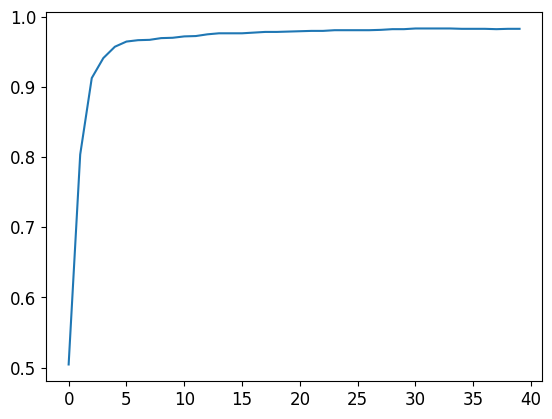

In [238]:
plt.plot(L(learner.recorder.values).itemgot(2));